In [1]:
import xarray as xr
import numpy as np
import pylab as plt
import cartopy.crs as ccrs
import cmocean
import copy as cp
from scipy.interpolate import griddata, interp1d
import pickle
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import get_cmap
import cartopy as cr
import matplotlib.cm as cm
from datetime import datetime as dtime
import matplotlib.colors as colors

# general functions

In [2]:
def re_grid_fucking_ORCA(Aplot):
    # Make the new grid
    lons_1d=np.linspace(0, 360, 721)
    lats_1d=np.linspace(65, 90, 51)
    lons_2d, lats_2d = np.meshgrid(lons_1d, lats_1d)
    try:
        lons=Aplot.Lons_360.values
    except:
        lons = cp.deepcopy(Aplot.llon_cc.values)
        lons[lons<0] = lons[lons<0]+360
    try:
        lats=Aplot.llat_cc.values
    except:
        lats = Aplot.nav_lat.values
    temp=Aplot.values
    lons=lons.flatten()
    lats=lats.flatten()
    temp=temp.flatten()

    
    temp_new = griddata((lons, lats), temp, (lons_2d, lats_2d), method='linear')
    
    dint = xr.Dataset(data_vars = {'Lats_reg':lats_1d, 'Lons_reg_360':lons_1d})
    dint['val'] = (('Lats_reg', 'Lons_reg_360'), temp_new)
    return dint

In [3]:
def plot_density_arctic(labs, lons, lats, n_clusters, vmax):
    lims = [-200, -90, 65, 90]
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    f = plt.figure(figsize = (15, 8))   

    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan

        # plot
        ax = f.add_subplot(np.max(labs)//6+1,6,nc+1, projection = ccrs.NorthPolarStereo())
        ax.coastlines(color='silver')
        ax.gridlines(zorder=-1)
        ax.set_extent(lims,  crs=ccrs.PlateCarree())
        ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')

        im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        ##im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=2.0,vmax=np.nanpercentile(hist,99)), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        Liste_hist.append(hist.T)
        ax.text(0.03, 0.05, '#'+str(nc), transform=ax.transAxes, fontsize=16)
        ax.text(0.8, 0.87, str(count), transform=ax.transAxes, fontsize=16)
        #plt.contour(lonb, latb, bathy, [350], colors='dimgrey', transform = ccrs.PlateCarree(), zorder=2)

        if nc==0:
            cbaxes = inset_axes(ax, width="50%", height="5%", loc=3) 
            cbar = plt.colorbar(im, cax=cbaxes, ticks=[0.,10,50], orientation='horizontal')
    return Liste_hist, f

In [4]:
def make_histo_arctic(labs, lons, lats, n_clusters):
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan
        Liste_hist.append(hist.T)
    return Liste_hist

In [5]:
def running_mean(t, x, N) :
    rm = np.convolve(x, np.ones((N,))/N, mode='valid')
    times = t[int(N/2):len(rm)+int(N/2)]
    return times, rm

# bathymetrie

In [6]:
# Load
ds_zgr =  xr.open_dataset('/storage/nplanat/Glorys12_masks/Mask_zgr_12.nc')
ds_zgr = ds_zgr.set_coords('nav_lat')
ds_zgr = ds_zgr.set_coords('nav_lon')
dsT = xr.open_dataset('/storage/nplanat/Glorys12_ORCA_mensuel/ext_arctic-GLORYS12V1_ORCA12_199408_gridT.nc')
dsT = dsT.set_coords('nav_lat')
dsT = dsT.set_coords('nav_lon')

Lons_360 = dsT.nav_lon.values
for x in range(dsT.nav_lon.shape[0]):
    for y in range(dsT.nav_lat.shape[1]):
        if Lons_360[x,y]<0:
            Lons_360[x,y] +=360
ds_zgr['Lons_360'] = (('y', 'x'), Lons_360)
ds_zgr = ds_zgr.set_coords('Lons_360')

bathy = re_grid_fucking_ORCA(ds_zgr.mbathy[0,:,:])

Text(0.5, 0, 'Bathymetry [m]')

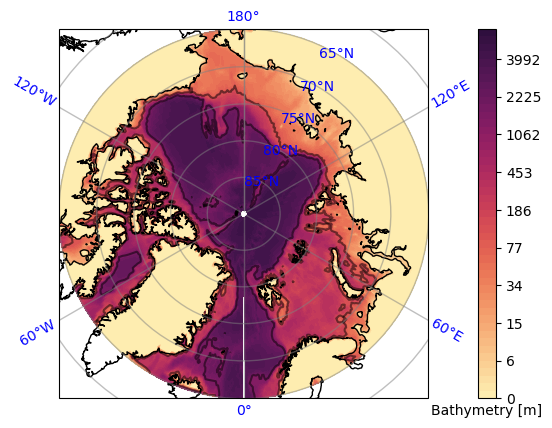

In [7]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
#ax.add_feature(cfeature.LAND)
ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
im = bathy.val.plot.contourf(levels =np.linspace(0, 50, 50), cmap =cmocean.cm.matter, ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl.xlabels = False
#gl.xlabels_bottom= False
gl.xlabel_style = {'color': 'blue'}
gl.ylabel_style = {'color': 'blue'}
cbarM = fig.colorbar(im, ticks = np.linspace(0, 50, 50)[0::5], ax = ax, orientation = 'vertical', pad = 0.1)#ticks =[-1.5, -1, -0.5]
cbarM.ax.set_yticklabels([str(int(x)) for x in ds_zgr.nav_lev.values[0::5]])
cbarM.ax.set_xlabel(r'Bathymetry [m]')


# Plot pathways from ML

## load classif

In [8]:
SUB_SETS = {'all':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/Sub_samp_y_1993_-_2014_delta_1_100000_start_lon_0.nc',\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/'},\
           'weird_path_only':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/Sub_samp_y_1996_-_1997_-delta_1_40000_start_lon_0.nc',\
                  'init_year':1996,\
                  'final_year':1997,\
                   'delta_year':1,\
                  'N_particles':40000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/'},\
           'without_weird_path':{'Subset_name':None,\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NO_WEIRD/'}}

In [9]:
sel_subset = 'all'
load_previous_run = True
init_year = SUB_SETS[sel_subset]['init_year']
final_year = SUB_SETS[sel_subset]['final_year']
delta_year = SUB_SETS[sel_subset]['delta_year']
Subset_name = SUB_SETS[sel_subset]['Subset_name']
N_particles = SUB_SETS[sel_subset]['N_particles']
Subset_path = SUB_SETS[sel_subset]['Subset_path']

files = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_new_*'))
files_m = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_m_200_*'))
files_s = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_s_200_*'))
length_days = 600
path_save_prediction = Subset_path 


perctest = 0.1 
perctrain = 0.8
trans = True

#PCA 
n_components = 0.9999999

# Clustering
init = 'k-means++'
nmb_initialisations = 20  # number of initiatilisaton for the k-means++ 
max_iter = 500
tol = 5e-4
algorithm = 'full'
verbose = 0 
sample_weight = None
n_split = 20  # number of iterations for convergence
n_clusters = 20 #number of clusters

In [10]:
#load PCA : 
with open(Subset_path + 'pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)
#load clustering : 
Traj_centroids = np.load(Subset_path+'Traj_centroids.npy', allow_pickle = True)
# load previous runs :
Labels_valid = np.load(path_save_prediction+'Labels_valid.npy')
Labels_test = np.load(path_save_prediction+'Labels_test.npy')
lats_test = np.load(path_save_prediction+'lats_test.npy')
lons_test = np.load(path_save_prediction+'lons_test.npy')
lats_train = np.load(path_save_prediction+'lats_train.npy')
lons_train = np.load(path_save_prediction+'lons_train.npy')
lats_valid = np.load(path_save_prediction+'lats_valid.npy')
lons_valid = np.load(path_save_prediction+'lons_valid.npy')

## Visualize

In [11]:
#Hist_valid = plot_density_arctic(Labels_valid, lons_valid, lats_valid, n_clusters, vmax = 50)

In [12]:
L1 = [1,9]#ACC
L2 = [2, 5, 7, 8, 10, 12, 13, 11,15]#Contourne BC
L3 = [4, 17]#eurasie
L4 = [1,9,0, 6, 14, 16, 18, 19]# Entre CB
L5 = [3] #Chukchi
#L6 = [8,9,1,4]#NWRidge
Groupes = [L1, L2,L3,L4, L5]#,L5]#, L6]#,L5,L6]
Names = [ 'ACC', 'Contourne BC', 'Eurasie', 'Entre CB', 'Chukchi shelf']#, 'NW Ridge']
LABS_SUPER = np.zeros(20)
for i in range(len(LABS_SUPER)):
    if i in Groupes[0]:
        LABS_SUPER[i] =3
    elif i in Groupes[1]:
        LABS_SUPER[i] =2
    elif i in Groupes[2]:
        LABS_SUPER[i] =1
    elif i in Groupes[3]:
        LABS_SUPER[i] =4
    elif i in Groupes[4]:
        LABS_SUPER[i] =5
    else:
        LABS_SUPER[i]= 0

In [13]:
def super_clusters(path_save_prediction, SUPP, n_clusters, Groupes, LABS_SUPER):
    for yr in range(1993,2014):
        try:
            labs_yr = np.load(path_save_prediction+SUPP+'labels_data_%i'%yr + '.npy', allow_pickle = True)
            labs_super = np.zeros(len(labs_yr))
            for i in range(len(labs_yr)):
                labs_super[i] = LABS_SUPER[labs_yr[i]]
            np.save(Subset_path+SUPP+'labels_super_%i'%yr, labs_super)
        except: 
            print('I miss year ', yr)
    return labs_super

In [14]:
def get_times_series_clustering(path_save_prediction, SUPP, n_clusters):
    Dates_all_s = []; Perc_labels_all_s = [];
    for yr in range(1993,2014):
        try:
            labs_yr = np.load(path_save_prediction+SUPP+'labels_data_%i'%yr + '.npy', allow_pickle = True)
            time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+SUPP+'times_%i'%yr+'.npy', allow_pickle = True)
            Date_data = np.unique(time_yr)
            Dates_all_s.extend(Date_data)
            Perc_labels = np.zeros((len(Date_data), n_clusters))
            for i in range(len(Date_data)):
                d0 = np.where(Date_data[i] ==time_yr)[0]
                for di in d0:
                    Perc_labels[i,labs_yr[di]] +=1
                Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
            Perc_labels_all_s.extend(Perc_labels)
        except: 
            print('I miss year ', yr)
    Perc_labels_all_s = np.array(Perc_labels_all_s)
    return Perc_labels_all_s, Dates_all_s

In [15]:
labs_super_s = super_clusters(path_save_prediction, 's_', n_clusters, Groupes, LABS_SUPER)
labs_super_m = super_clusters(path_save_prediction, 'm_', n_clusters, Groupes, LABS_SUPER)
labs_super = super_clusters(path_save_prediction, '', n_clusters, Groupes, LABS_SUPER)

In [16]:
Perc_labels_all_s, Dates_all_s = get_times_series_clustering(path_save_prediction, 's_', n_clusters)
Perc_labels_all_m, Dates_all_m = get_times_series_clustering(path_save_prediction, 'm_', n_clusters)
Perc_labels_all, Dates_all = get_times_series_clustering(path_save_prediction, '', n_clusters)

/tmp/ipykernel_2966278/4188188003.py:14: RuntimeWarning: invalid value encountered in true_divide
  Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4


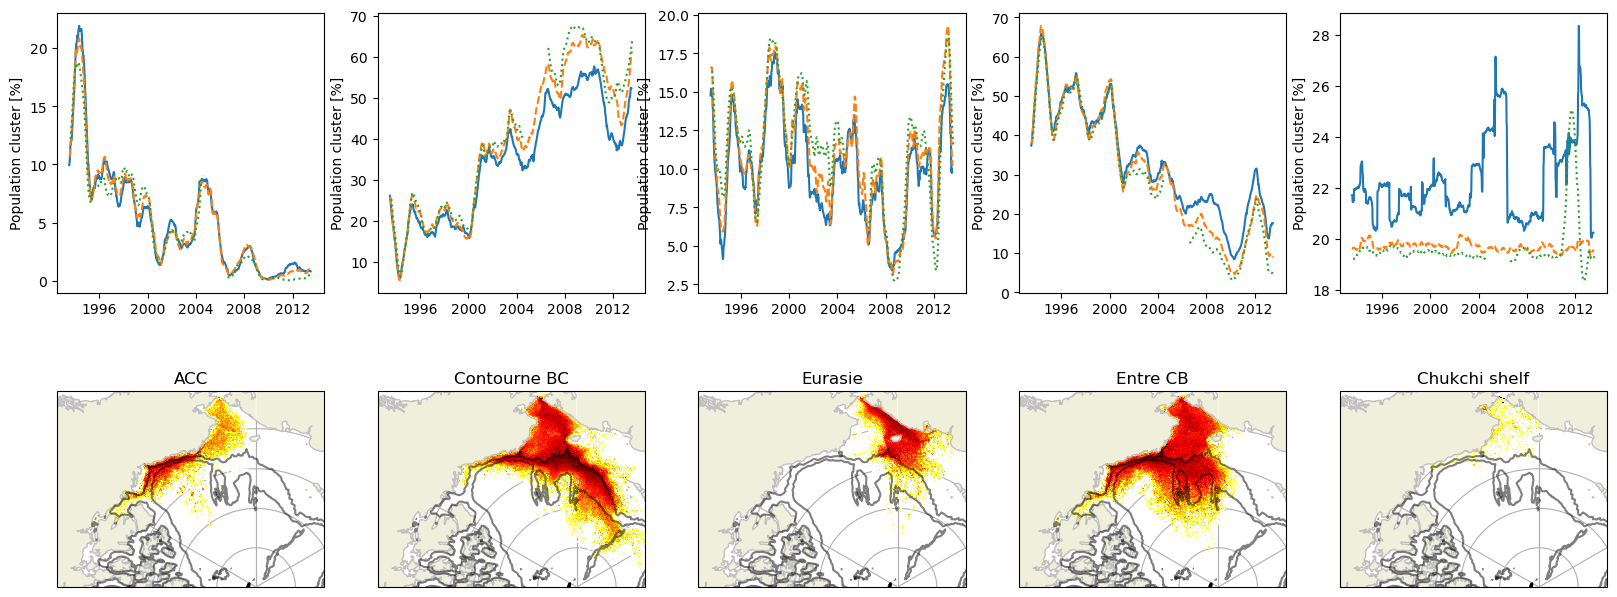

In [17]:
vmax = 300
Liste_h = make_histo_arctic(Labels_valid, lons_valid, lats_valid, n_clusters)
f = plt.figure(figsize = (len(Groupes)*4, 8))
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes),i+1)
    tm0,rm = running_mean(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm, '-', label = 'daily')
    tm0,rm = running_mean(Dates_all_m, np.sum(Perc_labels_all_m[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm, '--', label = 'monthly')
    tm0,rm = running_mean(Dates_all_s, np.sum(Perc_labels_all_s[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm, ':', label = '3-months')
    ax.set_ylabel('Population cluster [%]')
    ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())
    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
    ax.set_title(Names[i])


# Define relevant export zones - Masks

## Draw

In [18]:
MASK = np.zeros((bathy.Lats_reg.shape[0], bathy.Lons_reg_360.shape[0]))
ds_Mask = xr.Dataset(coords = {'Lats_reg':bathy.Lats_reg.values, 'Lons_reg_360':bathy.Lons_reg_360.values})
ds_Mask['MASK'] =  (('Lats_reg', 'Lons_reg_360'), MASK)

MASK_EURASIE = ds_Mask.MASK.where(ds_Mask.Lons_reg_360<=180, -1).where(bathy.val<18, -1).where(ds_Mask.Lons_reg_360>=120, -1).values +1
MASK_Contourne = ds_Mask.MASK.where(ds_Mask.Lons_reg_360<=180, -2).where(bathy.val>=18, -2).values +2
MASK_ACC = ds_Mask.MASK.where(ds_Mask.Lons_reg_360>=200, -3).where(ds_Mask.Lons_reg_360<=240, -3).where(bathy.val>1, -3).where(ds_Mask.Lats_reg<=73, -3).values +3
MASK_CB = ds_Mask.MASK.where(ds_Mask.Lons_reg_360>180, -4).where(ds_Mask.Lons_reg_360<=240, -4).where(bathy.val>37, -4).where(ds_Mask.Lats_reg>73, -4).values +4
MASK_Chuck = ds_Mask.MASK.where(ds_Mask.Lons_reg_360>180, -5).where(ds_Mask.Lons_reg_360<200, -5).where(bathy.val<=22, -5).values +5
MASK_trou = ds_Mask.MASK.where(ds_Mask.Lons_reg_360>180, -6).where(ds_Mask.Lons_reg_360<220, -6).where(ds_Mask.Lats_reg>73, -6).where(bathy.val>22, -6).where(bathy.val<=37, -6).values +6
#MASK_Contourne = ds_Mask.MASK.where(ds_Mask.Lons_reg_360<=180, -2).where(ds_Mask.Lats_reg>=72, -2).where(ds_Mask.Lats_reg<=80, -2).where(bathy.val>=18, -2).where(bathy.val<=38, -2).where(ds_Mask.Lons_reg_360>=140, -2).values +2

ds_Mask['MASK_EURASIE'] = (('Lats_reg', 'Lons_reg_360'), MASK_EURASIE) #`1
ds_Mask['MASK_CONTOURNE'] = (('Lats_reg', 'Lons_reg_360'), MASK_Contourne) #`2
ds_Mask['MASK_ACC'] = (('Lats_reg', 'Lons_reg_360'), MASK_ACC) #`3
ds_Mask['MASK_CB'] = (('Lats_reg', 'Lons_reg_360'), MASK_CB) #`4
ds_Mask['MASK_ALL'] = (('Lats_reg', 'Lons_reg_360'), MASK_Contourne+MASK_EURASIE+MASK_CB+MASK_ACC+ MASK_Chuck+MASK_trou) #trou : 6, chuk = 5

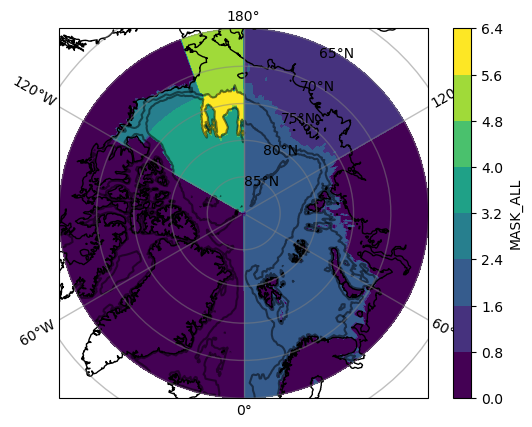

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
#ax.add_feature(cfeature.LAND)
ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
ds_Mask.MASK_ALL.plot.contourf(levels = 10,ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=True,  infer_intervals=True)       
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       

## Classify new mask

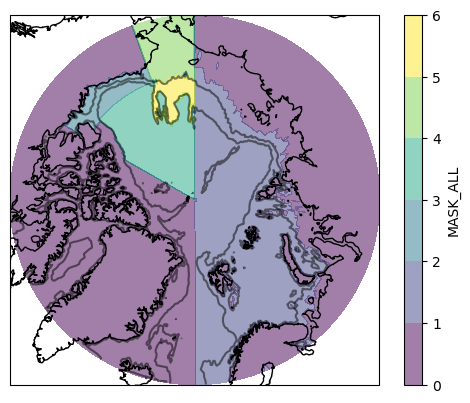

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
#ax.add_feature(cfeature.LAND)
ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
ds_Mask.MASK_ALL.plot.contourf(alpha = 0.5, levels = 7,ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=True,  infer_intervals=True)       
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       


## new labels

In [21]:
def get_new_labels_and_save_mask(ds_Mask, SUPP, yr, sp=1000):
    Lons_reg_360 = ds_Mask.Lons_reg_360.values
    Lats_reg = ds_Mask.Lats_reg.values
    lons_2d, lats_2d = np.meshgrid(Lons_reg_360, Lats_reg)

    LONS = lons_2d.flatten()
    LATS = lats_2d.flatten()
    MASK_ALL_TO = ds_Mask.MASK_ALL.values.flatten()
    print('Year', yr)
    #lats_all, lons_all, temps_all, sals_all, date_all = extract_all_per_year(yr, length_days, files)
    lats_all = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+SUPP+'lats_%i'%yr+'.npy', allow_pickle = True)
    lons_all = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+SUPP+'lons_%i'%yr+'.npy', allow_pickle = True)
    labels_all = []
    for sep in range(0,lats_all.shape[0],sp) :
        print(sep,'/',lats_all.shape[0])
        lats_all_l = lats_all[sep:sep+sp,:] ; lons_all_l = lons_all[sep:sep+sp,:]
        mask_valid = np.zeros((lats_all_l.shape))
        for i in range(lats_all_l.shape[0]):
            mask_valid[i,~np.isnan(lons_all_l[i,:])] = griddata((LONS, LATS), MASK_ALL_TO, (lons_all_l[i,~np.isnan(lons_all_l[i,:])], lats_all_l[i,~np.isnan(lons_all_l[i,:])]), method='nearest')

        labels_valid_mask = np.zeros(lons_all_l.shape[0])
        for i in range(len(mask_valid)):
            labels_valid_mask[i] = mask_valid[i,np.where(mask_valid[i,:]!=0)[0]][-1]

        labels_all.append(labels_valid_mask)    
           
    return labels_all              

In [22]:
def get_labs_mask_all_years(Subset_path, init_year,final_year, ds_Mask, sp, SUPP):
    for yr in range(init_year,final_year):
        print('Year', yr)
        try:
            Labs_mask = get_new_labels_and_save_mask(ds_Mask, SUPP, yr, sp = sp)
            Labs_mask = np.concatenate(Labs_mask, axis = 0)
            np.save(Subset_path+SUPP+'labels_mask_%i'%yr, Labs_mask)
        except:
            print('i MISS YEAR ' +str(yr))
    return None

In [155]:
#get_labs_mask_all_years(Subset_path, 2009,2014, ds_Mask, 5000, 's_')
#get_labs_mask_all_years(Subset_path, 1993,2014, ds_Mask, 5000, 'm_')
#get_labs_mask_all_years(Subset_path, 1993,2014, ds_Mask, 5000, '')

Year 2009
Year 2009
i MISS YEAR 2009
Year 2010
Year 2010
0 / 24630
5000 / 24630
10000 / 24630
15000 / 24630
20000 / 24630
Year 2011
Year 2011
0 / 23869
5000 / 23869
10000 / 23869
15000 / 23869
20000 / 23869
Year 2012
Year 2012
0 / 21600
5000 / 21600
10000 / 21600
15000 / 21600
20000 / 21600
Year 2013
Year 2013
0 / 24568
5000 / 24568
10000 / 24568
15000 / 24568
20000 / 24568
Year 1993
Year 1993
0 / 24562
5000 / 24562
10000 / 24562
15000 / 24562
20000 / 24562
Year 1994
Year 1994
0 / 24339
5000 / 24339
10000 / 24339
15000 / 24339
20000 / 24339
Year 1995
Year 1995
0 / 24475
5000 / 24475
10000 / 24475
15000 / 24475
20000 / 24475
Year 1996
Year 1996
0 / 24456
5000 / 24456
10000 / 24456
15000 / 24456
20000 / 24456
Year 1997
Year 1997
0 / 24417
5000 / 24417
10000 / 24417
15000 / 24417
20000 / 24417
Year 1998
Year 1998
0 / 24467
5000 / 24467
10000 / 24467
15000 / 24467
20000 / 24467
Year 1999
Year 1999
0 / 24496
5000 / 24496
10000 / 24496
15000 / 24496
20000 / 24496
Year 2000
Year 2000
0 / 2448

In [240]:
#get_labs_mask_all_years(Subset_path, 2005,2006, ds_Mask, 5000, 's_')

Year 2005
Year 2005
0 / 24631
5000 / 24631
10000 / 24631
15000 / 24631
20000 / 24631


In [23]:
def get_times_series_clustering_SC(path_save_prediction, SUPP, n_clusters):
    Dates_all_s = []; Perc_labels_all_s = [];
    for yr in range(1993,2014):
        try:
            labs_yr = np.load(path_save_prediction+SUPP+'labels_super_%i'%yr + '.npy', allow_pickle = True)
            time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+SUPP+'times_%i'%yr+'.npy', allow_pickle = True)
            Date_data = np.unique(time_yr)
            Dates_all_s.extend(Date_data)
            Perc_labels = np.zeros((len(Date_data), n_clusters))
            for i in range(len(Date_data)):
                d0 = np.where(Date_data[i] ==time_yr)[0]
                for di in d0:
                    Perc_labels[i,int(labs_yr[di])] +=1
                Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
            Perc_labels_all_s.extend(Perc_labels)
        except: 
            print('I miss year ', yr)
    Perc_labels_all_s = np.array(Perc_labels_all_s)
    return Perc_labels_all_s, Dates_all_s

In [24]:
def get_times_series_clustering_mask(path_save_prediction, SUPP, n_clusters):
    Dates_all_s = []; Perc_labels_all_s = [];
    for yr in range(1993,2014):
        try:
            labs_yr = np.load(path_save_prediction+SUPP+'labels_mask_%i'%yr + '.npy', allow_pickle = True)
            time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+SUPP+'times_%i'%yr+'.npy', allow_pickle = True)
            Date_data = np.unique(time_yr)
            Dates_all_s.extend(Date_data)
            Perc_labels = np.zeros((len(Date_data), n_clusters))
            for i in range(len(Date_data)):
                d0 = np.where(Date_data[i] ==time_yr)[0]
                for di in d0:
                    Perc_labels[i,int(labs_yr[di])] +=1
                Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
            Perc_labels_all_s.extend(Perc_labels)
        except: 
            print('I miss year ', yr)
    Perc_labels_all_s = np.array(Perc_labels_all_s)
    return Perc_labels_all_s, Dates_all_s

In [25]:
Perc_labels_all_s_mask, Dates_all_s_mask = get_times_series_clustering_mask(path_save_prediction, 's_', 7)
Perc_labels_all_m_mask, Dates_all_m_mask = get_times_series_clustering_mask(path_save_prediction, 'm_', 7)
Perc_labels_all_mask, Dates_all_mask = get_times_series_clustering_mask(path_save_prediction, '', 7)

/tmp/ipykernel_2966278/1376333788.py:14: RuntimeWarning: invalid value encountered in true_divide
  Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)


In [41]:
Perc_labels_all_s_SC, Dates_all_s_SC = get_times_series_clustering_SC(path_save_prediction, 's_', 7)
Perc_labels_all_m_SC, Dates_all_m_SC = get_times_series_clustering_SC(path_save_prediction, 'm_', 7)
Perc_labels_all_SC, Dates_all_SC = get_times_series_clustering_SC(path_save_prediction, '', 7)

/tmp/ipykernel_2966278/1909336725.py:14: RuntimeWarning: invalid value encountered in true_divide
  Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)


# Comparison

In [44]:
ds = xr.Dataset(coords = {'time':Dates_all_SC, 'labels':np.arange(7)})
ds['Perc_labels_all_SC'] = (('time', 'labels'), Perc_labels_all_SC)
ds['Perc_labels_all_m_SC'] = (('time', 'labels'), Perc_labels_all_m_SC)
#ds['Perc_labels_all_s_SC'] = (('time', 'labels'), Perc_labels_all_s_SC)
ds['Perc_labels_all_mask'] = (('time', 'labels'), Perc_labels_all_mask)
ds['Perc_labels_all_m_mask'] = (('time', 'labels'), Perc_labels_all_m_mask)
#ds['Perc_labels_all_s_mask'] = (('time', 'labels'), Perc_labels_all_s_mask)

SC_names = ['nan', 'Eurasie', 'Contourne', 'ACC', 'CB', 'Chukchi', 'NW']
M_names = ['nan', 'Eurasie', 'Contourne', 'ACC', 'CB', 'Chukchi', 'NW']

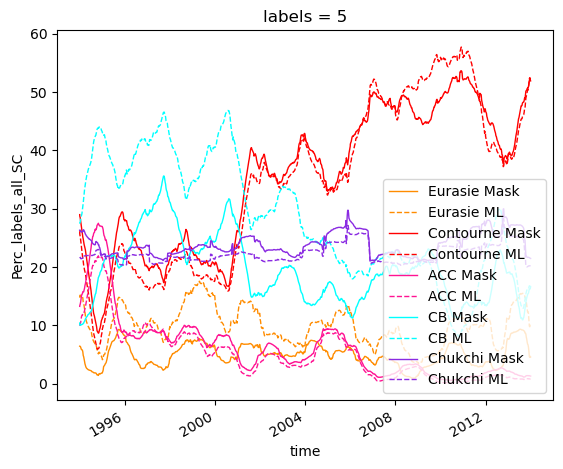

In [60]:
Colors = ['dimgrey', 'DarkOrange', 'red', 'deeppink', 'Aqua', 'blueviolet']
for i in range(1, 6):
    #ds.Perc_labels_all_m_mask.rolling(time = 53).mean().isel(labels =i).plot(label =M_names[i], linestyle = '-', linewidth = 2, c=Colors[i])
    ds.Perc_labels_all_mask.rolling(time = 53).mean().isel(labels =i).plot(linestyle = '-', linewidth = 1, c=Colors[i], label = M_names[i]+' Mask')
    ds.Perc_labels_all_SC.rolling(time = 53).mean().isel(labels =i).plot(linestyle = '--', linewidth = 1, c=Colors[i], label = M_names[i]+' ML')
    #ds.Perc_labels_all_m_SC.rolling(time = 53).mean().isel(labels =i).plot(linestyle = '--', linewidth =1, c=Colors[i])
ax = plt.gca()
ax.legend(loc = 'lower right')


In [62]:
Labels_valid_super = np.zeros(len(Labels_valid))
for i in range(len(Labels_valid)):
    Labels_valid_super[i] = LABS_SUPER[Labels_valid[i]]

In [63]:
Lons_reg_360 = ds_Mask.Lons_reg_360.values
Lats_reg = ds_Mask.Lats_reg.values
lons_2d, lats_2d = np.meshgrid(Lons_reg_360, Lats_reg)

LONS = lons_2d.flatten()
LATS = lats_2d.flatten()
MASK_ALL_TO = ds_Mask.MASK_ALL.values.flatten()

mask_valid = np.zeros((lats_valid.shape))
for i in range(lats_valid.shape[0]):
    mask_valid[i,~np.isnan(lons_valid[i,:])] = griddata((LONS, LATS), MASK_ALL_TO, (lons_valid[i,~np.isnan(lons_valid[i,:])], lats_valid[i,~np.isnan(lons_valid[i,:])]), method='nearest')

labels_valid_mask = np.zeros(lons_valid.shape[0])
for i in range(len(mask_valid)):
    labels_valid_mask[i] = mask_valid[i,np.where(mask_valid[i,:]!=0)[0]][-1]           

Text(0.5, 1.0, 'Mask = Eurasie, ML = CB')

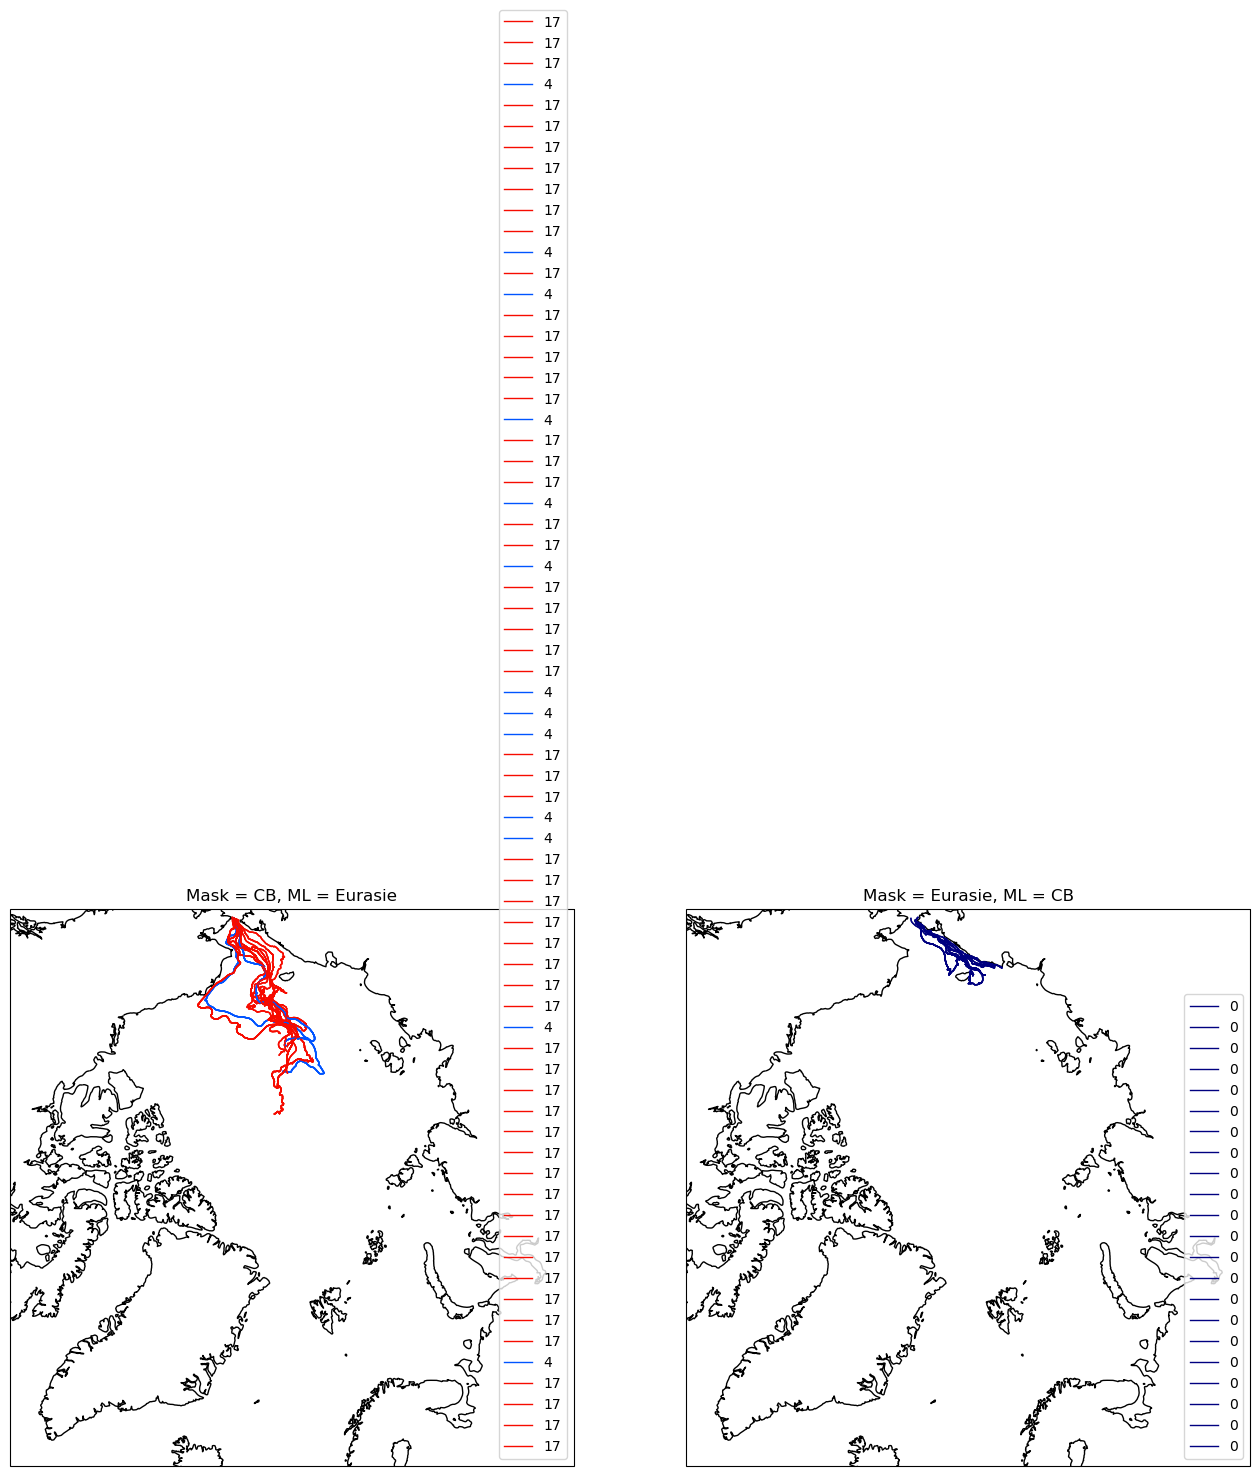

In [82]:
cmap = plt.cm.jet(np.linspace(0,1,20))

fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(1,2,1,  projection = ccrs.NorthPolarStereo())
ax2 = fig.add_subplot(1,2,2,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax2.coastlines()
#ax.add_feature(cfeature.LAND)

for n in [np.random.randint(len(Labels_valid_super)) for x in range(50000)]:
    if Labels_valid_super[n]==1 and labels_valid_mask[n]==4: 
        ax.plot(lons_valid[n], lats_valid[n],  transform=ccrs.PlateCarree(), lw = 1, c = cmap[Labels_valid[n]], label = str(Labels_valid[n]))
    elif Labels_valid_super[n]==4 and labels_valid_mask[n]==1: 
        ax2.plot(lons_valid[n], lats_valid[n], transform =ccrs.PlateCarree(), lw = 1, c = cmap[Labels_valid[n]], label = str(Labels_valid[n]))
ax.set_extent([-200, 90, 65, 90], crs=ccrs.PlateCarree())
ax.legend(loc = 'lower right')
ax.set_title('Mask = CB, ML = Eurasie')
ax2.set_extent([-200, 90, 65, 90], crs=ccrs.PlateCarree())
ax2.legend(loc = 'lower right')
ax2.set_title('Mask = Eurasie, ML = CB')


groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5


(0.0, 70.0)

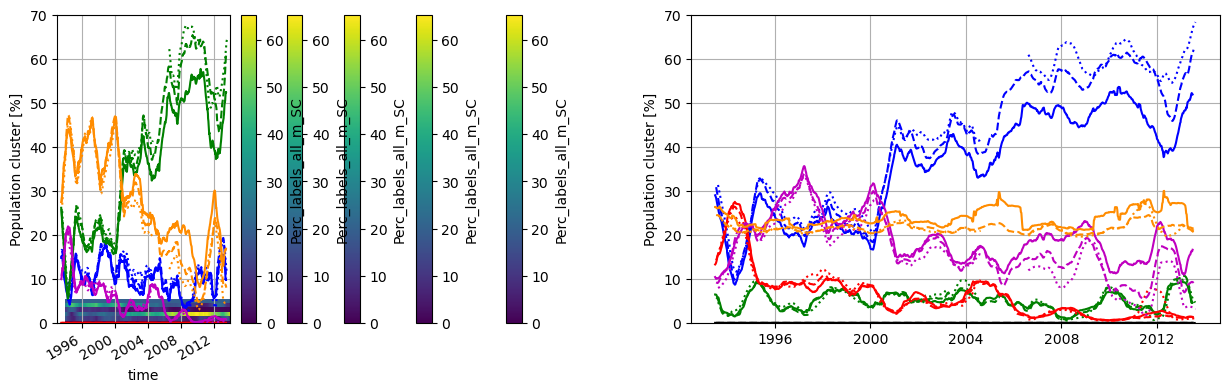

In [305]:
Names_m = ['Undefined', 'Eurasie', 'Coutourne', 'ACC', 'CB', 'Chukchi', 'NW']
f = plt.figure(figsize = (15, 4))
ax = f.add_subplot(1,2,1)
Colors = ['r', 'b', 'g', 'm', 'DarkOrange', 'k']
for i in range(len(Groupes)):
    print('groupe, ', i)
    tm0, rm = running_mean(Dates_all_SC,Perc_labels_all_SC[:,i], 53)
    ax.plot(tm0, rm, label = 'Daily '+Names[i], ls= '-', c = Colors[i])
    ds.Perc_labels_all_m_SC.rolling(time = 53).mean().plot(x = 'time')
    tm0, rm = running_mean(Dates_all_m_SC, Perc_labels_all_m_SC[:,i], 53)
    ax.plot(tm0, rm, label = 'Monthly '+Names[i], ls = '--',c = Colors[i])    
    tm0, rm = running_mean(Dates_all_s_SC, Perc_labels_all_s_SC[:,i], 53)
    ax.plot(tm0, rm, label = 'Seas '+Names[i], ls = ':', c = Colors[i])
    ax.set_ylabel('Population cluster [%]')
    
ax.grid('on')
#ax.legend(loc= 'upper left')
ax.set_ylim([0, 70])
ax = f.add_subplot(1,2,2)
Colors = ['k', 'g', 'b', 'r', 'm', 'DarkOrange']
for i in range(6):
    print('groupe, ', i), Dates_all_s_mask
    tm0, rm = running_mean(Dates_all_mask,Perc_labels_all_mask[:,i], 53)
    ax.plot(tm0, rm, label = 'Daily '+Names_m[i], ls= '-', c = Colors[i])
    tm0, rm = running_mean(Dates_all_m_mask, Perc_labels_all_m_mask[:,i], 53)
    ax.plot(tm0, rm, label = 'Monthly '+Names_m[i], ls = '--',c = Colors[i])    
    tm0, rm = running_mean(Dates_all_s_mask, Perc_labels_all_s_mask[:,i], 53)
    #ax.plot(Dates_all_s_mask, Perc_labels_all_s_mask[:, i], label = 'Seas '+Names_m[i], ls = ':', c = Colors[i])
    ax.plot(tm0, rm, label = 'Seas '+Names_m[i], ls = ':',c = Colors[i])    
    ax.set_ylabel('Population cluster [%]')
    
ax.grid('on')
#ax.legend(loc= 'upper left')
ax.set_ylim([0, 70])

#ax.set_xlim([dtime(year = 2004, month = 1, day = 1), dtime(year = 2008, month = 1, day = 1)])

In [199]:
tm0, rm = running_mean(Dates_all_SC,Perc_labels_all_SC[:,0], 53)

Dates_all_SC

[numpy.datetime64('1993-01-01T12:00:00.000000000'),
 numpy.datetime64('1993-01-08T12:00:00.000000000'),
 numpy.datetime64('1993-01-15T12:00:00.000000000'),
 numpy.datetime64('1993-01-22T12:00:00.000000000'),
 numpy.datetime64('1993-01-29T12:00:00.000000000'),
 numpy.datetime64('1993-02-05T12:00:00.000000000'),
 numpy.datetime64('1993-02-12T12:00:00.000000000'),
 numpy.datetime64('1993-02-19T12:00:00.000000000'),
 numpy.datetime64('1993-02-26T12:00:00.000000000'),
 numpy.datetime64('1993-03-05T12:00:00.000000000'),
 numpy.datetime64('1993-03-12T12:00:00.000000000'),
 numpy.datetime64('1993-03-19T12:00:00.000000000'),
 numpy.datetime64('1993-03-26T12:00:00.000000000'),
 numpy.datetime64('1993-04-02T12:00:00.000000000'),
 numpy.datetime64('1993-04-09T12:00:00.000000000'),
 numpy.datetime64('1993-04-16T12:00:00.000000000'),
 numpy.datetime64('1993-04-23T12:00:00.000000000'),
 numpy.datetime64('1993-04-30T12:00:00.000000000'),
 numpy.datetime64('1993-05-07T12:00:00.000000000'),
 numpy.datet